In [ ]:
%matplotlib inline


Reconstruct a synthetic signal from its scattering transform
============================================================
In this example we generate a harmonic signal of a few different frequencies,
analyze it with the 1D scattering transform, and reconstruct the scattering
transform back to the harmonic signal.


Import the necessary packages
-----------------------------



In [1]:
import numpy as np
import torch
from kymatio.torch import Scattering1D

from torch.autograd import backward
import matplotlib.pyplot as plt

Write a function that can generate a harmonic signal
----------------------------------------------------
Let's write a function that can generate some simple blip-type sounds with
decaying harmonics. It will take four arguments: T, the length of the output
vector; num_intervals, the number of different blips; gamma, the exponential
decay factor of the harmonic; random_state, a random seed to generate
random pitches and phase shifts.
The function proceeds by splitting the time length T into intervals, chooses
base frequencies and phases, generates sinusoidal sounds and harmonics,
and then adds a windowed version to the output signal.



In [2]:
def generate_harmonic_signal(T, num_intervals=4, gamma=0.9, random_state=42):
    """
    Generates a harmonic signal, which is made of piecewise constant notes
    (of random fundamental frequency), with half overlap
    """
    rng = np.random.RandomState(random_state)
    num_notes = 2 * (num_intervals - 1) + 1
    support = T // num_intervals
    half_support = support // 2

    base_freq = 0.1 * rng.rand(num_notes) + 0.05
    phase = 2 * np.pi * rng.rand(num_notes)
    window = np.hanning(support)
    x = np.zeros(T, dtype='float32')
    t = np.arange(0, support)
    u = 2 * np.pi * t
    for i in range(num_notes):
        ind_start = i * half_support
        note = np.zeros(support)
        for k in range(1):
            note += (np.power(gamma, k) *
                     np.cos(u * (k + 1) * base_freq[i] + phase[i]))
        x[ind_start:ind_start + support] += note * window

    return x

Let’s take a look at what such a signal could look like.



Text(0.5, 1.0, 'Original signal')

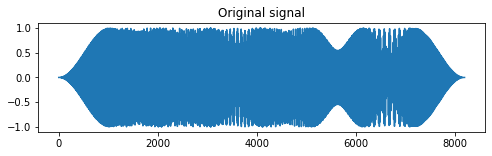

In [3]:
T = 2 ** 13
x = torch.from_numpy(generate_harmonic_signal(T))
plt.figure(figsize=(8, 2))
plt.plot(x.numpy())
plt.title("Original signal")

Let’s take a look at the signal spectrogram.



Text(0.5, 1.0, 'Spectrogram of original signal')

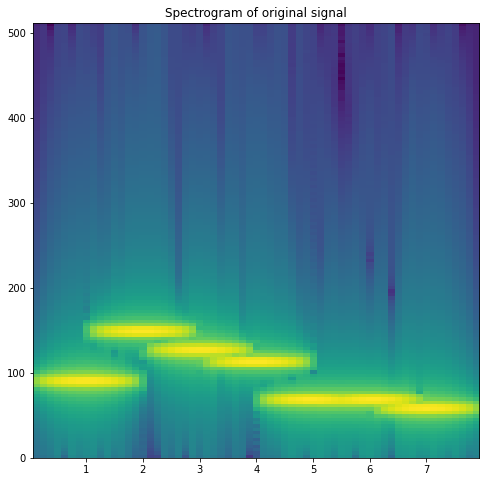

In [4]:
plt.figure(figsize=(8, 8))
plt.specgram(x.numpy(), Fs=1024)
plt.title("Spectrogram of original signal")

# Doing the scattering transform.



In [5]:
J = 6
Q = 16

scattering = Scattering1D(J, T, Q)

Sx = scattering(x)

learning_rate = 100
bold_driver_accelerator = 1.1
bold_driver_brake = 0.55
n_iterations = 200

/home/sikun/anaconda3/envs/py38/lib/python3.8/site-packages/kymatio/scattering1d/backend/torch_backend.py:134: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:567.)
  fft = FFT(lambda x: torch.fft(x, 1, normalized=False),
/home/sikun/anaconda3/envs/py38/lib/python3.8/site-packages/kymatio/scattering1d/backend/torch_backend.py:136: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/aten/src/ATen/native/SpectralOps.cpp:602.)
  lambda x: torch.irfft(x, 1, normalized=False, onesided=False),

Reconstruct the scattering transform back to original signal.



Iteration   0, loss 5.85
Iteration  10, loss 0.95
Iteration  20, loss 0.62
Iteration  30, loss 0.46
Iteration  40, loss 0.40
Iteration  50, loss 0.37
Iteration  60, loss 0.35
Iteration  70, loss 0.34
Iteration  80, loss 0.33
Iteration  90, loss 0.31
Iteration 100, loss 0.31
Iteration 110, loss 0.30
Iteration 120, loss 0.29
Iteration 130, loss 0.28
Iteration 140, loss 0.27
Iteration 150, loss 0.27
Iteration 160, loss 0.26
Iteration 170, loss 0.26
Iteration 180, loss 0.25
Iteration 190, loss 0.25


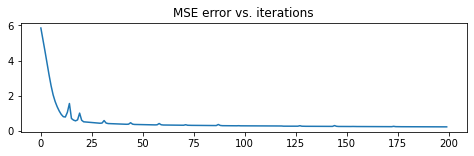

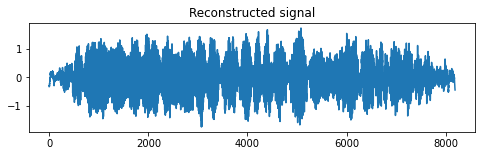

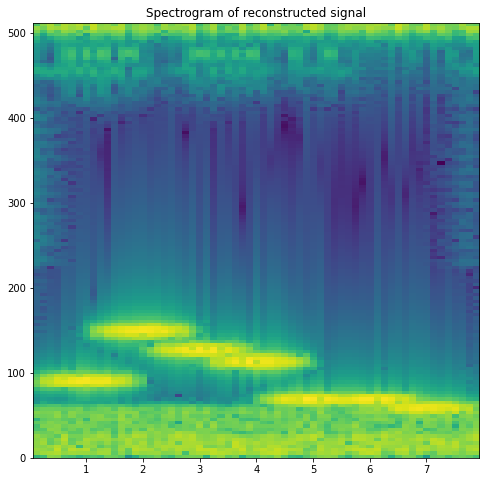

In [6]:
# Random guess to initialize.
torch.manual_seed(0)
y = torch.randn((T,), requires_grad=True)
Sy = scattering(y)

history = []
signal_update = torch.zeros_like(x)

# Iterate to recontsruct random guess to be close to target.
for k in range(n_iterations):
    # Backpropagation.
    err = torch.norm(Sx - Sy)

    if k % 10 == 0:
        print('Iteration %3d, loss %.2f' % (k, err.detach().numpy()))

    # Measure the new loss.
    history.append(err)

    backward(err)

    delta_y = y.grad

    # Gradient descent
    with torch.no_grad():
        signal_update = - learning_rate * delta_y
        new_y = y + signal_update
    new_y.requires_grad = True

    # New forward propagation.
    Sy = scattering(new_y)

    if history[k] > history[k - 1]:
        learning_rate *= bold_driver_brake
    else:
        learning_rate *= bold_driver_accelerator
        y = new_y

plt.figure(figsize=(8, 2))
plt.plot(history)
plt.title("MSE error vs. iterations")

plt.figure(figsize=(8, 2))
plt.plot(y.detach().numpy())
plt.title("Reconstructed signal")

plt.figure(figsize=(8, 8))
plt.specgram(y.detach().numpy(), Fs=1024)
plt.title("Spectrogram of reconstructed signal")

plt.show()